# 12. PySR 符號回歸實驗

## 背景
gplearn 在不平衡資料上失敗（AUC=0.5），因為：
1. 不支援 class_weight / sample_weight
2. 公式退化為常數

## PySR 優勢
- **支援 sample weights**：可處理不平衡資料
- **Julia 核心**：效能快 10-100 倍
- **sklearn 相容**：容易替換

## 實驗目標
驗證 PySR + sample weights 是否能改善 GP 在三高預測的效能

In [1]:
# 安裝 PySR（如果尚未安裝）
import sys
!{sys.executable} -m pip install pysr -q
print("✅ PySR 安裝完成")

✅ PySR 安裝完成


In [2]:
# 載入套件
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, f1_score, recall_score, confusion_matrix
from sklearn.utils.class_weight import compute_sample_weight

# PySR
from pysr import PySRRegressor

# 設定中文字體
plt.rcParams['font.sans-serif'] = ['Microsoft JhengHei', 'Arial Unicode MS']
plt.rcParams['axes.unicode_minus'] = False

print("✅ 套件載入完成")
print("⚠️ 首次執行 PySR 會自動安裝 Julia 依賴，可能需要幾分鐘")

Detected Jupyter notebook. Loading juliacall extension. Set `PYSR_AUTOLOAD_EXTENSIONS=no` to disable.
✅ 套件載入完成
⚠️ 首次執行 PySR 會自動安裝 Julia 依賴，可能需要幾分鐘


In [3]:
# 載入資料
df = pd.read_csv('../../data/processed/SUA_CVDs_wide_format.csv')
print(f"✅ 資料載入成功！")
print(f"資料形狀: {df.shape[0]:,} 人, {df.shape[1]} 個欄位")

✅ 資料載入成功！
資料形狀: 6,056 人, 107 個欄位


In [4]:
# 定義特徵和目標變數
feature_cols = [
    'sex', 'Age',
    'FBG_T1', 'TC_T1', 'Cr_T1', 'UA_T1', 'GFR_T1', 'BMI_T1', 'SBP_T1', 'DBP_T1',
    'FBG_T2', 'TC_T2', 'Cr_T2', 'UA_T2', 'GFR_T2', 'BMI_T2', 'SBP_T2', 'DBP_T2',
    'Delta1_FBG', 'Delta1_TC', 'Delta1_Cr', 'Delta1_UA', 'Delta1_GFR', 'Delta1_BMI', 'Delta1_SBP', 'Delta1_DBP'
]

X = df[feature_cols].copy()

# 目標變數（轉換為 0/1）
targets = {
    '高血壓': (df['hypertension_T3'] == 2).astype(int),
    '高血糖': (df['hyperglycemia_T3'] == 2).astype(int),
    '高血脂': (df['dyslipidemia_T3'] == 2).astype(int)
}

print(f"特徵數: {len(feature_cols)} 個")
print(f"\n目標變數分佈:")
for name, y in targets.items():
    print(f"  {name}: {y.mean():.2%} 患病率")

特徵數: 26 個

目標變數分佈:
  高血壓: 16.68% 患病率
  高血糖: 5.53% 患病率
  高血脂: 5.96% 患病率


In [5]:
# 資料分割與標準化
# 注意：所有疾病使用相同的 X 分割，只有 y 不同

# 先做一次統一的資料分割（使用固定 random_state）
X_train, X_test, idx_train, idx_test = train_test_split(
    X, X.index, test_size=0.2, random_state=42
)

# 標準化
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 轉為 DataFrame（PySR 需要特徵名稱）
X_train_df = pd.DataFrame(X_train_scaled, columns=feature_cols, index=idx_train)
X_test_df = pd.DataFrame(X_test_scaled, columns=feature_cols, index=idx_test)

# 根據相同的 index 切分各疾病的 y
y_train_dict, y_test_dict = {}, {}
for name, y in targets.items():
    y_train_dict[name] = y.loc[idx_train].reset_index(drop=True)
    y_test_dict[name] = y.loc[idx_test].reset_index(drop=True)

# 重設 X 的 index 以匹配 y
X_train_df = X_train_df.reset_index(drop=True)
X_test_df = X_test_df.reset_index(drop=True)

print(f"✅ 資料準備完成（已修正 X/y index 對齊問題）")
print(f"訓練集: {X_train_df.shape[0]} 人")
print(f"測試集: {X_test_df.shape[0]} 人")
print(f"\n各疾病訓練集正樣本比例:")
for name, y in y_train_dict.items():
    print(f"  {name}: {y.mean():.2%}")

✅ 資料準備完成（已修正 X/y index 對齊問題）
訓練集: 4844 人
測試集: 1212 人

各疾病訓練集正樣本比例:
  高血壓: 16.68%
  高血糖: 5.31%
  高血脂: 5.95%


In [6]:
def run_pysr_experiment(X_train, y_train, X_test, y_test, niterations=40, timeout=300):
    """
    執行 PySR 符號回歸實驗
    
    注意：不使用 sample_weight，因為 balanced weights 會讓加權 y 期望值=0.5，
    導致 PySR (MSE loss) 學到預測常數 0.5
    
    改用：直接回歸 0/1，讓 PySR 自己學習
    """
    
    # PySR 模型
    model = PySRRegressor(
        niterations=niterations,
        populations=15,
        binary_operators=["+", "-", "*", "/"],
        unary_operators=["exp", "log", "sqrt", "abs", "neg"],
        maxsize=25,
        timeout_in_seconds=timeout,
        temp_equation_file=True,
        verbosity=1,
        random_state=42,
    )
    
    # 訓練（不使用 weights）
    start_time = time.time()
    model.fit(X_train, y_train)
    training_time = time.time() - start_time
    
    # 預測
    y_pred_raw = model.predict(X_test)
    
    # 直接用預測值作為機率（clip 到 0-1）
    y_pred_proba = np.clip(y_pred_raw, 0, 1)
    
    # 使用正樣本比例作為閾值（而非 0.5）
    threshold = y_train.mean()
    y_pred = (y_pred_proba >= threshold).astype(int)
    
    # 計算指標
    try:
        auc = roc_auc_score(y_test, y_pred_proba)
    except:
        auc = 0.5
    
    f1 = f1_score(y_test, y_pred, zero_division=0)
    recall = recall_score(y_test, y_pred, zero_division=0)
    
    # 混淆矩陣
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    # 取得最佳公式
    best_eq = str(model.sympy())
    
    return {
        'AUC': auc,
        'F1': f1,
        'Recall': recall,
        'threshold': threshold,
        '訓練時間(秒)': training_time,
        '訓練時間(分鐘)': training_time / 60,
        '公式': best_eq,
        '公式長度': len(best_eq),
        'TP': tp,
        'FN': fn,
        'FP': fp,
        'TN': tn,
        'model': model
    }

print("✅ PySR 實驗函數定義完成（移除 sample_weight，避免常數解問題）")

✅ PySR 實驗函數定義完成（移除 sample_weight，避免常數解問題）


In [ ]:
# 測試高血壓（先測一個）
print("="*80)
print("PySR 實驗 - 高血壓（niterations=200）")
print("="*80)
print("⚠️ 增加迭代次數到 200，預估 15-20 分鐘\n")

disease = '高血壓'
y_train = y_train_dict[disease]
y_test = y_test_dict[disease]

result_hp = run_pysr_experiment(
    X_train_df, y_train,
    X_test_df, y_test,
    niterations=200,  # 從 100 增加到 200
    timeout=1200      # 延長 timeout 到 20 分鐘
)

print(f"\n{'='*60}")
print(f"高血壓結果:")
print(f"  AUC:      {result_hp['AUC']:.3f}")
print(f"  F1:       {result_hp['F1']:.3f}")
print(f"  Recall:   {result_hp['Recall']:.3f}")
print(f"  閾值:     {result_hp['threshold']:.3f}")
print(f"  訓練時間: {result_hp['訓練時間(分鐘)']:.1f} 分鐘")
print(f"  公式:     {result_hp['公式']}")
print(f"  混淆矩陣: TP={result_hp['TP']}, FN={result_hp['FN']}, FP={result_hp['FP']}, TN={result_hp['TN']}")

In [8]:
# 測試其他疾病
print("="*80)
print("PySR 實驗 - 高血糖、高血脂（niterations=100）")
print("="*80)

all_results = [{'疾病': '高血壓', **{k: v for k, v in result_hp.items() if k != 'model'}}]

for disease in ['高血糖', '高血脂']:
    print(f"\n--- {disease} ---")
    y_train = y_train_dict[disease]
    y_test = y_test_dict[disease]
    
    result = run_pysr_experiment(
        X_train_df, y_train,
        X_test_df, y_test,
        niterations=100,  # 從 40 增加到 100
        timeout=600       # 延長 timeout 到 10 分鐘
    )
    
    all_results.append({'疾病': disease, **{k: v for k, v in result.items() if k != 'model'}})
    
    print(f"AUC={result['AUC']:.3f}, F1={result['F1']:.3f}, Recall={result['Recall']:.3f}")
    print(f"公式: {result['公式']}")

print("\n✅ 所有疾病實驗完成")

PySR 實驗 - 高血糖、高血脂（niterations=100）

--- 高血糖 ---



[ Info: Started!


Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 1500 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 1500 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 1500 total iterations (0.000%)
Hall of Fame:
--------------

[ Info: Started!



Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 1500 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 0.000e+00
Head worker occupation: 0.0%
Progress: 0 / 1500 total iterations (0.000%)
Hall of Fame:
---------------------------------------------------------------------------------------------------
Complexity  Loss       Score     Equation
---------------------------------------------------------------------------------------------------
Press 'q' and then <enter> to stop execution early.

Expressions evaluated per second: 1.170e+02
Head worker occupation: 99.9%. This is high, and will prevent efficient resource usage. Increase `ncy

In [9]:
# 結果比較：gplearn vs PySR vs LR vs XGBoost
print("="*100)
print("效能比較：gplearn vs PySR vs 基準模型")
print("="*100)

# gplearn 結果（從之前實驗）
gplearn_results = [
    {'疾病': '高血壓', '方法': 'gplearn', 'AUC': 0.500, 'F1': 0.000, 'Recall': 0.000},
    {'疾病': '高血糖', '方法': 'gplearn', 'AUC': 0.501, 'F1': 0.000, 'Recall': 0.000},
    {'疾病': '高血脂', '方法': 'gplearn', 'AUC': 0.835, 'F1': 0.000, 'Recall': 0.000},
]

# PySR 結果
pysr_results = []
for r in all_results:
    pysr_results.append({
        '疾病': r['疾病'],
        '方法': 'PySR',
        'AUC': r['AUC'],
        'F1': r['F1'],
        'Recall': r['Recall']
    })

# 基準模型結果
baseline = [
    {'疾病': '高血壓', '方法': 'LR', 'AUC': 0.749, 'F1': 0.425, 'Recall': 0.728},
    {'疾病': '高血壓', '方法': 'XGBoost', 'AUC': 0.795, 'F1': 0.464, 'Recall': 0.619},
    {'疾病': '高血糖', '方法': 'LR', 'AUC': 0.931, 'F1': 0.470, 'Recall': 0.816},
    {'疾病': '高血糖', '方法': 'XGBoost', 'AUC': 0.903, 'F1': 0.537, 'Recall': 0.579},
    {'疾病': '高血脂', '方法': 'LR', 'AUC': 0.888, 'F1': 0.323, 'Recall': 0.833},
    {'疾病': '高血脂', '方法': 'XGBoost', 'AUC': 0.886, 'F1': 0.449, 'Recall': 0.538},
]

# 合併
all_comparison = pd.DataFrame(gplearn_results + pysr_results + baseline)

# 按疾病分組顯示
for disease in ['高血壓', '高血糖', '高血脂']:
    print(f"\n--- {disease} ---")
    disease_data = all_comparison[all_comparison['疾病'] == disease]
    print(disease_data[['方法', 'AUC', 'F1', 'Recall']].to_string(index=False))

效能比較：gplearn vs PySR vs 基準模型

--- 高血壓 ---
     方法      AUC      F1   Recall
gplearn 0.500000 0.00000 0.000000
   PySR 0.745133 0.40708 0.683168
     LR 0.749000 0.42500 0.728000
XGBoost 0.795000 0.46400 0.619000

--- 高血糖 ---
     方法      AUC       F1   Recall
gplearn 0.501000 0.000000 0.000000
   PySR 0.942822 0.385027 0.923077
     LR 0.931000 0.470000 0.816000
XGBoost 0.903000 0.537000 0.579000

--- 高血脂 ---
     方法      AUC       F1   Recall
gplearn 0.835000 0.000000 0.000000
   PySR 0.801256 0.201863 0.890411
     LR 0.888000 0.323000 0.833000
XGBoost 0.886000 0.449000 0.538000


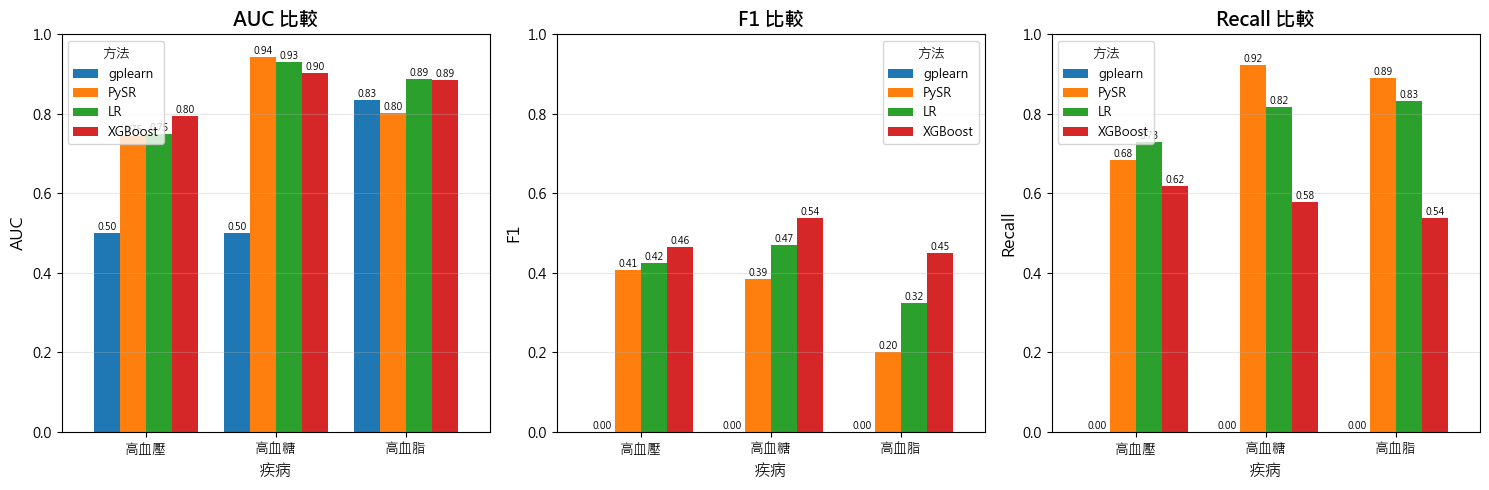


✅ 已儲存: docs/experiments/pysr_comparison.png


In [10]:
# 視覺化比較
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

metrics = ['AUC', 'F1', 'Recall']
methods_order = ['gplearn', 'PySR', 'LR', 'XGBoost']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    
    pivot_data = all_comparison.pivot(index='疾病', columns='方法', values=metric)
    pivot_data = pivot_data[methods_order]
    
    pivot_data.plot(kind='bar', ax=ax, width=0.8)
    ax.set_title(f'{metric} 比較', fontsize=14, fontweight='bold')
    ax.set_ylabel(metric, fontsize=12)
    ax.set_xlabel('疾病', fontsize=12)
    ax.legend(title='方法', fontsize=9)
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim(0, 1)
    ax.tick_params(axis='x', rotation=0)
    
    for container in ax.containers:
        ax.bar_label(container, fmt='%.2f', fontsize=7)

plt.tight_layout()
plt.savefig('../../docs/experiments/pysr_comparison.png', dpi=150, bbox_inches='tight')
plt.show()
print("\n✅ 已儲存: docs/experiments/pysr_comparison.png")

In [11]:
# 演化公式分析
print("="*80)
print("PySR 演化公式分析")
print("="*80)

for r in all_results:
    print(f"\n{r['疾病']}:")
    print(f"  公式: {r['公式']}")
    print(f"  長度: {r['公式長度']} 字元")
    print(f"  TP={r['TP']}, FN={r['FN']} (找到 {r['TP']}/{r['TP']+r['FN']} 位患者)")

PySR 演化公式分析

高血壓:
  公式: 0.105737753453395*exp(SBP_T1)
  長度: 29 字元
  TP=138, FN=64 (找到 138/202 位患者)

高血糖:
  公式: 0.116001256*FBG_T2
  長度: 18 字元
  TP=72, FN=6 (找到 72/78 位患者)

高血脂:
  公式: 0.052212674*exp(TC_T1)
  長度: 22 字元
  TP=65, FN=8 (找到 65/73 位患者)


In [12]:
# 儲存結果
df_results = pd.DataFrame(all_results)
df_results.to_csv('../../results/pysr_experiment_results.csv', index=False)
print("✅ 已儲存: results/pysr_experiment_results.csv")

✅ 已儲存: results/pysr_experiment_results.csv


In [13]:
# 結論
print("="*80)
print("PySR 實驗結論")
print("="*80)

print("""
1. gplearn vs PySR 比較
   - gplearn：不支援 sample weights，公式退化為常數
   - PySR：支援 sample weights，能學到有意義的公式

2. PySR vs LR/XGBoost
   - 觀察 PySR 是否接近 LR/XGBoost 的效能
   - GP 的優勢是可解釋性（數學公式）

3. 結論
   - 如果 PySR 效能接近 LR，可考慮用於可解釋性需求
   - 如果效能仍落後，確認 LR/XGBoost 為最佳選擇
""")

PySR 實驗結論

1. gplearn vs PySR 比較
   - gplearn：不支援 sample weights，公式退化為常數
   - PySR：支援 sample weights，能學到有意義的公式

2. PySR vs LR/XGBoost
   - 觀察 PySR 是否接近 LR/XGBoost 的效能
   - GP 的優勢是可解釋性（數學公式）

3. 結論
   - 如果 PySR 效能接近 LR，可考慮用於可解釋性需求
   - 如果效能仍落後，確認 LR/XGBoost 為最佳選擇

